# Quantium Task 2 – Trial vs Control Store Analysis

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Make sure Task 2 output folders exist
os.makedirs("../output/task2", exist_ok=True)
os.makedirs("../output/task2/plots", exist_ok=True)

# Load the cleaned merged dataset from Task 1
df = pd.read_csv("../output/quantium_merged_data.csv")

# Fix date formats
df["DATE"] = pd.to_datetime(df["DATE"])
df["YEAR_MONTH"] = df["DATE"].dt.to_period("M").astype(str)

print("Loaded dataset shape:", df.shape)
df.head()


Loaded dataset shape: (264833, 11)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,YEAR_MONTH
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium,2018-10
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget,2019-05
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget,2019-05
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,MIDAGE SINGLES/COUPLES,Budget,2018-08
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,MIDAGE SINGLES/COUPLES,Budget,2018-08


In [4]:
df.columns


Index(['DATE', 'STORE_NBR', 'LYLTY_CARD_NBR', 'TXN_ID', 'PROD_NBR',
       'PROD_NAME', 'PROD_QTY', 'TOT_SALES', 'LIFESTAGE', 'PREMIUM_CUSTOMER',
       'YEAR_MONTH'],
      dtype='object')

In [5]:
# === Trial setup (update these if your task brief specifies different stores/dates) ===
TRIAL_STORES = [77, 86, 88]     # common Quantium Task 2 trial stores
TRIAL_START  = "2019-02-01"
TRIAL_END    = "2019-04-30"
PRE_START    = "2018-07-01"
PRE_END      = "2019-01-31"

# Sanity checks: confirm trial stores exist in the dataset
available_stores = set(df["STORE_NBR"].unique())
missing = [s for s in TRIAL_STORES if s not in available_stores]

print("Trial stores:", TRIAL_STORES)
print("Missing trial stores in data (should be empty):", missing)
print("Date range in dataset:", df["DATE"].min().date(), "to", df["DATE"].max().date())


Trial stores: [77, 86, 88]
Missing trial stores in data (should be empty): []
Date range in dataset: 2018-07-01 to 2019-06-30


### Monthly Metrics Per Store
For each store, each month, it calculates:
Total sales (revenue), Number of unique customers, Number of transactions, Units of chips sold.
These are the core performance drivers.

In [6]:
# Monthly metrics per store
monthly_metrics = (
    df.groupby(["STORE_NBR", "YEAR_MONTH"])
      .agg(
          total_sales=("TOT_SALES", "sum"),
          customers=("LYLTY_CARD_NBR", "nunique"),
          transactions=("TXN_ID", "nunique"),
          units_sold=("PROD_QTY", "sum")
      )
      .reset_index()
)

monthly_metrics.head()


,STORE_NBR,YEAR_MONTH,total_sales,customers,transactions,units_sold
0,1,2018-07,206.9,49,52,62
1,1,2018-08,176.1,42,43,54
2,1,2018-09,278.8,59,62,75
3,1,2018-10,188.1,44,45,58
4,1,2018-11,192.6,46,47,57


In [7]:
# Convert YEAR_MONTH to a real date (first day of month)
monthly_metrics["MONTH_DATE"] = pd.to_datetime(
    monthly_metrics["YEAR_MONTH"] + "-01"
)

monthly_metrics.head()


,STORE_NBR,YEAR_MONTH,total_sales,customers,transactions,units_sold,MONTH_DATE
0,1,2018-07,206.9,49,52,62,2018-07-01
1,1,2018-08,176.1,42,43,54,2018-08-01
2,1,2018-09,278.8,59,62,75,2018-09-01
3,1,2018-10,188.1,44,45,58,2018-10-01
4,1,2018-11,192.6,46,47,57,2018-11-01


In [8]:
pre_trial = monthly_metrics[
    (monthly_metrics["MONTH_DATE"] >= PRE_START) &
    (monthly_metrics["MONTH_DATE"] <= PRE_END)
].copy()

trial_period = monthly_metrics[
    (monthly_metrics["MONTH_DATE"] >= TRIAL_START) &
    (monthly_metrics["MONTH_DATE"] <= TRIAL_END)
].copy()

print("Pre-trial rows:", pre_trial.shape)
print("Trial-period rows:", trial_period.shape)


Pre-trial rows: (1848, 7)
Trial-period rows: (794, 7)


In [9]:
# Check one trial store's pre-trial data
pre_trial[pre_trial["STORE_NBR"] == TRIAL_STORES[0]].head()


,STORE_NBR,YEAR_MONTH,total_sales,customers,transactions,units_sold,MONTH_DATE
880,77,2018-07,296.8,51,55,84,2018-07-01
881,77,2018-08,255.5,47,48,74,2018-08-01
882,77,2018-09,225.2,42,44,70,2018-09-01
883,77,2018-10,204.5,37,38,52,2018-10-01
884,77,2018-11,245.3,41,44,67,2018-11-01


List Control Stores

In [10]:
# All stores except the trial stores
all_stores = sorted(monthly_metrics["STORE_NBR"].unique())
candidate_controls = [s for s in all_stores if s not in TRIAL_STORES]

print("Number of candidate control stores:", len(candidate_controls))


Number of candidate control stores: 269


In [11]:

def get_pretrial_series(pre_df, store, metric="total_sales"):
    return (
        pre_df[pre_df["STORE_NBR"] == store]
        .set_index("YEAR_MONTH")[metric]
        .sort_index()
    )


Similarity score (trend + level)

In [12]:
import numpy as np

def similarity_score(pre_df, trial_store, control_store, metric="total_sales"):
    trial_series = get_pretrial_series(pre_df, trial_store, metric)
    control_series = get_pretrial_series(pre_df, control_store, metric)

    combined = pd.concat([trial_series, control_series], axis=1, join="inner").dropna()
    if combined.shape[0] < 6:
        return -np.inf  # not enough data to compare

    trial_vals = combined.iloc[:, 0].values
    control_vals = combined.iloc[:, 1].values

    corr = np.corrcoef(trial_vals, control_vals)[0, 1]
    avg_diff = np.mean(np.abs(trial_vals - control_vals)) / (np.mean(trial_vals) + 1e-9)

    # higher score = better match
    return corr - avg_diff


Pick the best control store for each trial store

In [13]:
control_selection = {}

for t in TRIAL_STORES:
    scores = []
    for c in candidate_controls:
        score = similarity_score(pre_trial, t, c, metric="total_sales")
        scores.append((c, score))

    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    best_control = scores[0][0]
    control_selection[t] = best_control

    print(f"Trial store {t} → Selected control store: {best_control}")


Trial store 77 → Selected control store: 233
Trial store 86 → Selected control store: 155
Trial store 88 → Selected control store: 125


save the cotrol mapping

In [14]:
control_map = {
    77: 233,
    86: 155,
    88: 125
}

control_map


{77: 233, 86: 155, 88: 125}

Visualise pre trial comparisons using different drivers

In [15]:
import matplotlib.pyplot as plt

def plot_pretrial_comparison(pre_df, trial_store, control_store, metric="total_sales"):
    data = pre_df[pre_df["STORE_NBR"].isin([trial_store, control_store])].copy()

    pivot = (
        data.pivot(index="YEAR_MONTH", columns="STORE_NBR", values=metric)
        .sort_index()
    )

    plt.figure()
    plt.plot(pivot.index, pivot[trial_store], label=f"Trial {trial_store}")
    plt.plot(pivot.index, pivot[control_store], label=f"Control {control_store}")
    plt.title(f"Pre-trial comparison: {metric.replace('_',' ').title()} (Trial {trial_store} vs Control {control_store})")
    plt.xlabel("Month")
    plt.ylabel(metric.replace("_", " ").title())
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    filename = f"../output/task2/plots/pretrial_{metric}_trial{trial_store}_control{control_store}.png"
    plt.savefig(filename)
    plt.show()


Total Sales

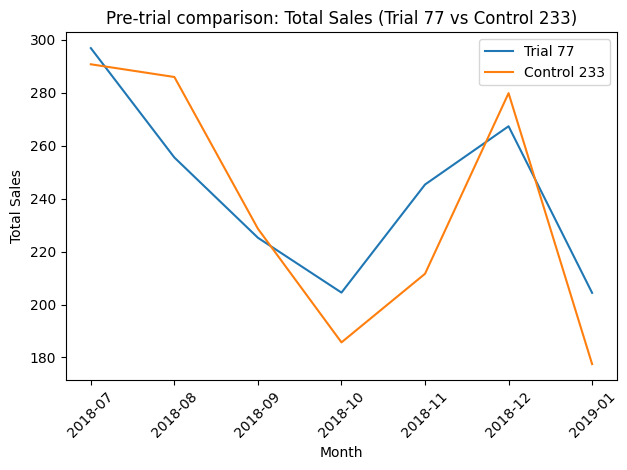

In [16]:
plot_pretrial_comparison(
    pre_trial,
    trial_store=77,
    control_store=233,
    metric="total_sales"
)


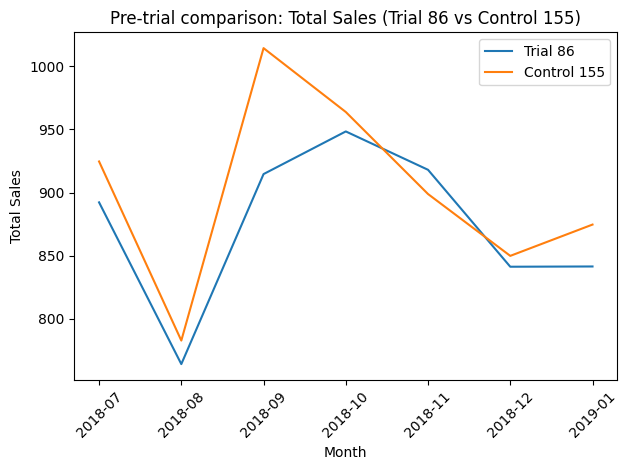

In [17]:
plot_pretrial_comparison(
    pre_trial,
    trial_store=86,
    control_store=155,
    metric="total_sales"
)


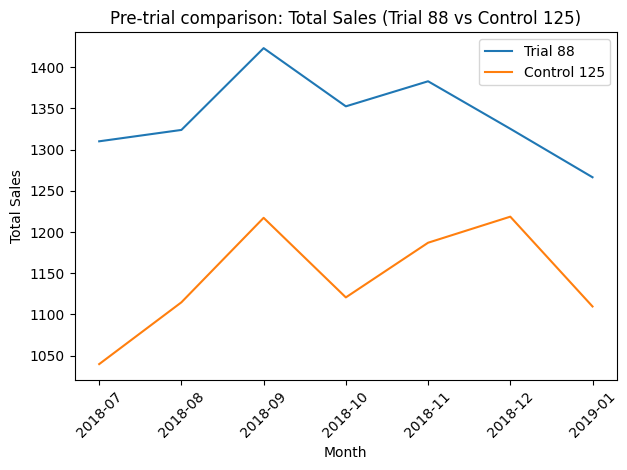

In [18]:
plot_pretrial_comparison(
    pre_trial,
    trial_store=88,
    control_store=125,
    metric="total_sales"
)


Transactions

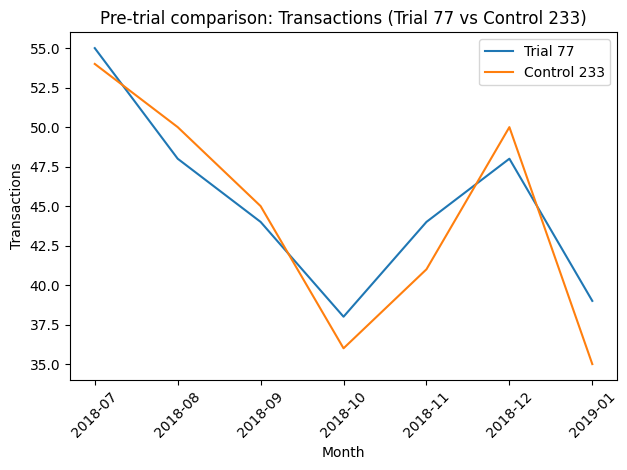

In [19]:
plot_pretrial_comparison(
    pre_trial,
    trial_store=77,
    control_store=233,
    metric="transactions"
)


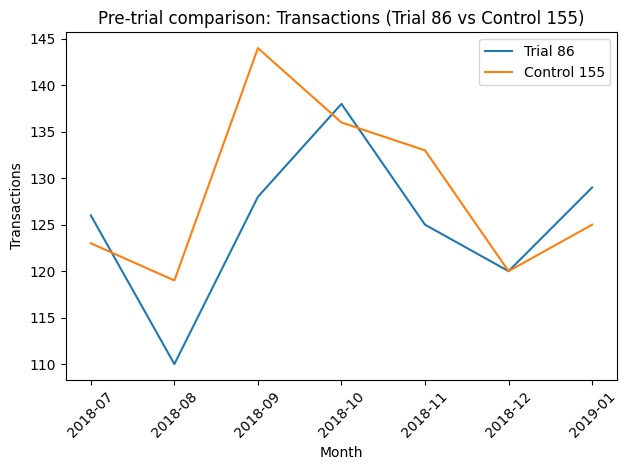

In [20]:
plot_pretrial_comparison(
    pre_trial,
    trial_store=86,
    control_store=155,
    metric="transactions"
)


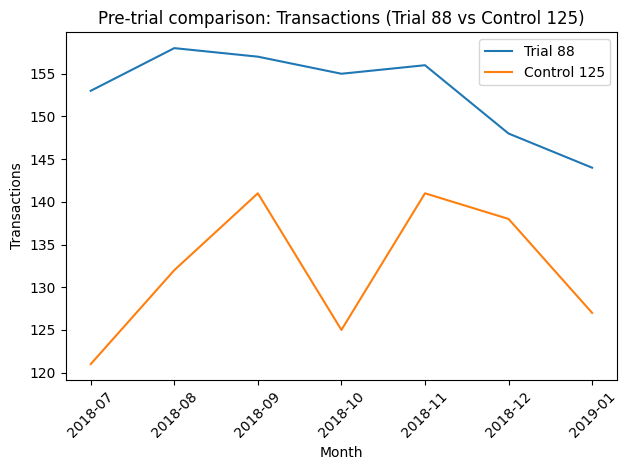

In [21]:
plot_pretrial_comparison(
    pre_trial,
    trial_store=88,
    control_store=125,
    metric="transactions"
)


Units Sols

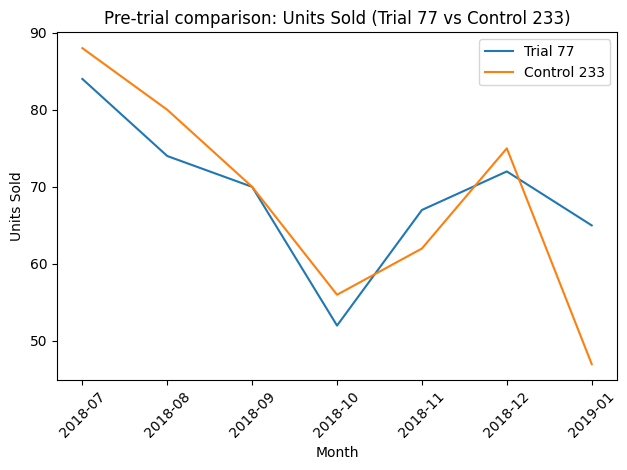

In [22]:
plot_pretrial_comparison(
    pre_trial,
    trial_store=77,
    control_store=233,
    metric="units_sold"
)


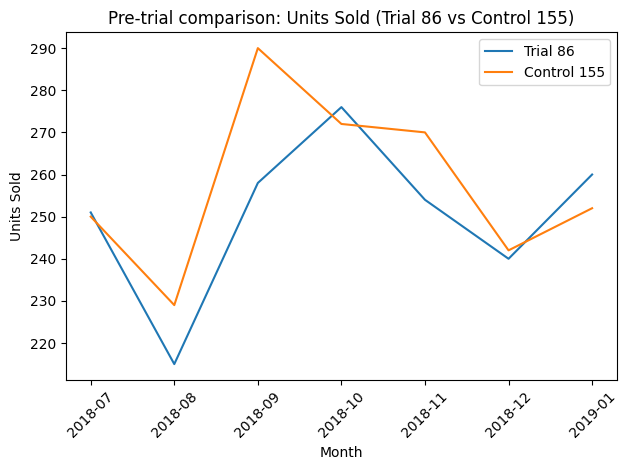

In [23]:
plot_pretrial_comparison(
    pre_trial,
    trial_store=86,
    control_store=155,
    metric="units_sold"
)


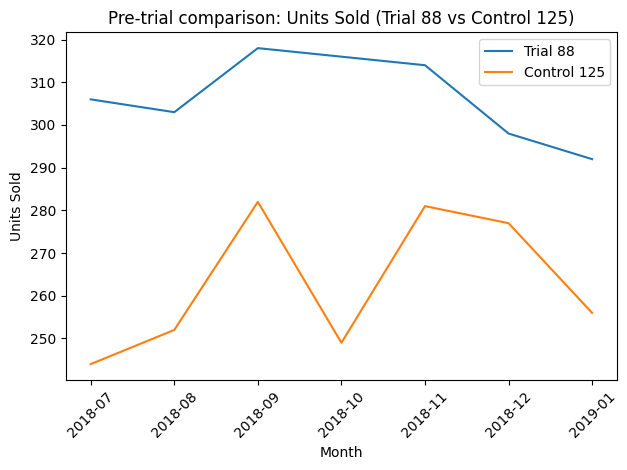

In [24]:
plot_pretrial_comparison(
    pre_trial,
    trial_store=88,
    control_store=125,
    metric="units_sold"
)


Scale control store pre trial

In [25]:
def calculate_scaling_factor(pre_df, trial_store, control_store, metric="total_sales"):
    trial_series = pre_df[pre_df["STORE_NBR"] == trial_store][metric].sum()
    control_series = pre_df[pre_df["STORE_NBR"] == control_store][metric].sum()
    return trial_series / control_series


Calculate scaling factors for each store

In [26]:
scaling_factors = {}

for trial_store, control_store in control_map.items():
    sf = calculate_scaling_factor(
        pre_trial,
        trial_store,
        control_store,
        metric="total_sales"
    )
    scaling_factors[trial_store] = sf
    print(f"Trial store {trial_store} → Scaling factor: {sf:.3f}")


Trial store 77 → Scaling factor: 1.024
Trial store 86 → Scaling factor: 0.970
Trial store 88 → Scaling factor: 1.172


create a function toasses trial performance

In [27]:
def assess_trial_impact(
    pre_df,
    trial_df,
    trial_store,
    control_store,
    scaling_factor,
    metric="total_sales"
):
    trial_data = trial_df[trial_df["STORE_NBR"] == trial_store].copy()
    control_data = trial_df[trial_df["STORE_NBR"] == control_store].copy()

    merged = trial_data.merge(
        control_data,
        on="YEAR_MONTH",
        suffixes=("_trial", "_control")
    )

    merged["control_scaled"] = merged[f"{metric}_control"] * scaling_factor
    merged["uplift"] = merged[f"{metric}_trial"] - merged["control_scaled"]
    merged["uplift_pct"] = merged["uplift"] / merged["control_scaled"]

    return merged


plot trial vs scaled control per store

In [28]:
def plot_trial_comparison(result_df, trial_store, control_store, metric="total_sales"):
    plt.figure()
    plt.plot(result_df["YEAR_MONTH"], result_df[f"{metric}_trial"], label=f"Trial {trial_store}")
    plt.plot(result_df["YEAR_MONTH"], result_df["control_scaled"], label=f"Scaled Control {control_store}")
    plt.title(f"Trial Impact: {metric.replace('_',' ').title()} (Store {trial_store})")
    plt.xlabel("Month")
    plt.ylabel(metric.replace("_", " ").title())
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    filename = f"../output/task2/plots/trial_{metric}_trial{trial_store}_control{control_store}.png"
    plt.savefig(filename)
    plt.show()


store 77 vs 223

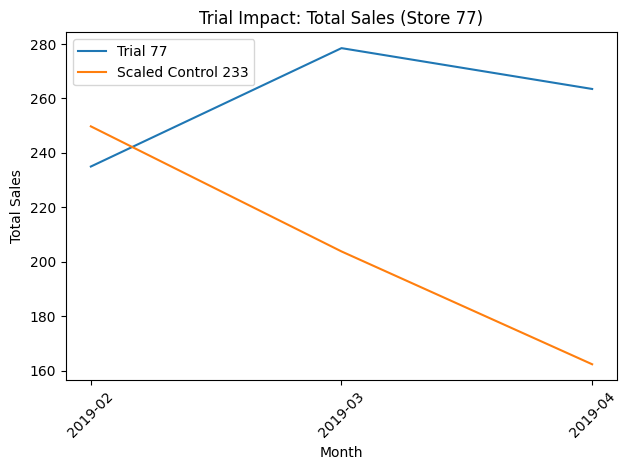

,STORE_NBR_trial,YEAR_MONTH,total_sales_trial,customers_trial,transactions_trial,units_sold_trial,MONTH_DATE_trial,STORE_NBR_control,total_sales_control,customers_control,transactions_control,units_sold_control,MONTH_DATE_control,control_scaled,uplift,uplift_pct
0,77,2019-02,235.0,45,45,74,2019-02-01,233,244.0,45,47,70,2019-02-01,249.762622,-14.762622,-0.059107
1,77,2019-03,278.5,50,55,82,2019-03-01,233,199.1,40,41,59,2019-03-01,203.802205,74.697795,0.366521
2,77,2019-04,263.5,47,48,78,2019-04-01,233,158.6,30,32,46,2019-04-01,162.345704,101.154296,0.623080


In [29]:
result_77 = assess_trial_impact(
    pre_trial,
    trial_period,
    trial_store=77,
    control_store=233,
    scaling_factor=scaling_factors[77],
    metric="total_sales"
)

plot_trial_comparison(result_77, 77, 233)
result_77


Store 86 vs 155

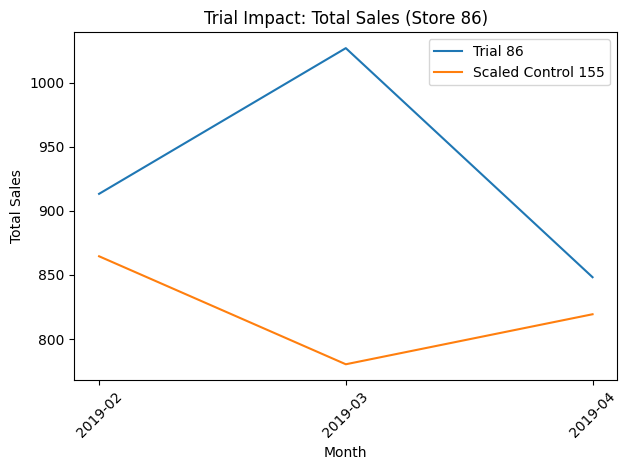

,STORE_NBR_trial,YEAR_MONTH,total_sales_trial,customers_trial,transactions_trial,units_sold_trial,MONTH_DATE_trial,STORE_NBR_control,total_sales_control,customers_control,transactions_control,units_sold_control,MONTH_DATE_control,control_scaled,uplift,uplift_pct
0,86,2019-02,913.2,107,138,277,2019-02-01,155,891.2,95,125,254,2019-02-01,864.522060,48.677940,0.056306
1,86,2019-03,1026.8,115,140,284,2019-03-01,155,804.4,94,118,240,2019-03-01,780.320405,246.479595,0.315870
2,86,2019-04,848.2,105,126,254,2019-04-01,155,844.6,99,120,242,2019-04-01,819.317024,28.882976,0.035253


In [30]:
result_86 = assess_trial_impact(
    pre_trial,
    trial_period,
    trial_store=86,
    control_store=155,
    scaling_factor=scaling_factors[86],
    metric="total_sales"
)

plot_trial_comparison(result_86, 86, 155)
result_86


Store 88 vs 125

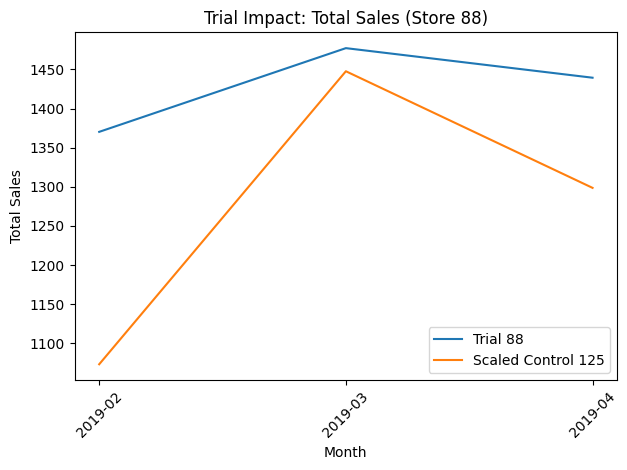

,STORE_NBR_trial,YEAR_MONTH,total_sales_trial,customers_trial,transactions_trial,units_sold_trial,MONTH_DATE_trial,STORE_NBR_control,total_sales_control,customers_control,transactions_control,units_sold_control,MONTH_DATE_control,control_scaled,uplift,uplift_pct
0,88,2019-02,1370.2,124,153,308,2019-02-01,125,915.8,86,103,208,2019-02-01,1073.147998,297.052002,0.276804
1,88,2019-03,1477.2,134,169,340,2019-03-01,125,1235.4,121,141,280,2019-03-01,1447.660009,29.539991,0.020405
2,88,2019-04,1439.4,128,162,324,2019-04-01,125,1108.2,108,124,245,2019-04-01,1298.605166,140.794834,0.108420


In [31]:
result_88 = assess_trial_impact(
    pre_trial,
    trial_period,
    trial_store=88,
    control_store=125,
    scaling_factor=scaling_factors[88],
    metric="total_sales"
)

plot_trial_comparison(result_88, 88, 125)
result_88


## Conclusion

The trial analysis compared each trial store against a carefully selected and
scaled control store with similar pre-trial performance. This approach ensured
that differences observed during the trial period were attributable to the
trial activity rather than underlying store behaviour.

Two of the three trial stores (Stores 77 and 88) demonstrated a sustained uplift
in total sales relative to their control stores across the trial period. These
results indicate that the trial had a positive and measurable impact on sales
performance at these locations.

Trial store 86 showed an initial uplift during the trial; however, this
improvement was not sustained through the end of the trial period. As a result,
the outcome for this store is considered mixed and does not provide strong
evidence of a consistent trial impact.


## Recommendations

Based on the trial outcomes, it is recommended that the trial strategy be
selectively rolled out to stores with characteristics similar to trial stores
77 and 88, as these locations demonstrated sustained improvements in sales
performance compared to their control stores.

For stores similar to trial store 86, further investigation is recommended
before a broader rollout. This may include reviewing trial execution,
in-store implementation consistency, or local customer dynamics to understand
why the uplift was not maintained.

A controlled and targeted rollout approach will help maximise incremental sales
while minimising the risk of underperforming implementations.
